In [1]:
import numpy as np
import os

from keras.src.utils.module_utils import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D,BatchNormalization, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D

from matplotlib.image import imread
import matplotlib.pyplot as plt
import random


In [2]:
# File Directory for both the train and test
train_path = "C:\\Users\\yaren\\PycharmProjects\\ResNet50-ChestCancer-Detection\\Data\\train"
val_path = "C:\\Users\\yaren\\PycharmProjects\\ResNet50-ChestCancer-Detection\\Data\\valid"
test_path = "C:\\Users\\yaren\\PycharmProjects\\ResNet50-ChestCancer-Detection\\Data\\test"

In [3]:
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range= 0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   preprocessing_function=preprocess_input,
                                   dtype="float32")


test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 dtype="float32")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 dtype="float32")


In [4]:
train_data = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode="categorical",
                                               )
test_data = test_datagen.flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode="categorical",
                                             shuffle=False)
val_data = val_datagen.flow_from_directory(val_path,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode="categorical",
                                           shuffle=False)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [5]:
from mobilenetv2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from mobilenetv2 import MobileNetV2  # kendi dosyan

base_model = MobileNetV2(
    include_top=False,          # Fully-connected katmanları kaldır
    weights="imagenet",         # Önceden eğitilmiş ImageNet ağırlıklarını kullan
    input_tensor=None,          # Varsayılan giriş tensörünü kullan
    input_shape=(224, 224, 3),  # Görüntü boyutu (224x224 RGB)
    pooling="avg",              # Global Average Pooling kullan (yoğunluğu azaltır)
    classes=4,                  # 4 sınıf için (senin veri setine göre)
    classifier_activation="softmax"  # Çıkış aktivasyonu (çok sınıflı sınıflandırma için)
)

base_model.summary()


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [33]:
for layer in base_model.layers:
    layer.trainable = False
model1 = Sequential([
    base_model,
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')  # NUM_CLASSES = 4
])



In [34]:
# Modeli derle
model1.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
checkpoint = ModelCheckpoint("best_VGG16_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.5, verbose=1)

history = model1.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=2
)



Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.76389, saving model to best_VGG16_model.keras
20/20 - 14s - 711ms/step - accuracy: 0.6933 - loss: 1.1850 - val_accuracy: 0.7639 - val_loss: 0.9839 - learning_rate: 1.0000e-03
Epoch 2/30

Epoch 2: val_accuracy improved from 0.76389 to 0.79167, saving model to best_VGG16_model.keras
20/20 - 11s - 555ms/step - accuracy: 0.8874 - loss: 0.4061 - val_accuracy: 0.7917 - val_loss: 0.9327 - learning_rate: 1.0000e-03
Epoch 3/30

Epoch 3: val_accuracy did not improve from 0.79167
20/20 - 11s - 546ms/step - accuracy: 0.8972 - loss: 0.2715 - val_accuracy: 0.7639 - val_loss: 1.0384 - learning_rate: 1.0000e-03
Epoch 4/30

Epoch 4: val_accuracy improved from 0.79167 to 0.80556, saving model to best_VGG16_model.keras
20/20 - 11s - 557ms/step - accuracy: 0.9086 - loss: 0.2412 - val_accuracy: 0.8056 - val_loss: 0.8651 - learning_rate: 1.0000e-03
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.80556
20/20 - 11s - 546ms/step - accuracy: 0.9

In [5]:
from tensorflow.keras.models import load_model
saved_model = load_model("ct_mobilenetv2_best_model.keras")

In [36]:
score = saved_model.evaluate(test_data, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - accuracy: 0.6837 - loss: 0.7069
Test loss: 0.6626492142677307
Test accuracy: 0.6984127163887024


In [37]:
test_loss, test_acc = saved_model.evaluate(test_data, verbose=1)
print("\n📊 TEST SET:")
print(f"✅ Accuracy: {test_acc:.4f}")
print(f"❌ Loss:     {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 420ms/step - accuracy: 0.6837 - loss: 0.7069

📊 TEST SET:
✅ Accuracy: 0.6984
❌ Loss:     0.6626


In [38]:
train_loss, train_acc = saved_model.evaluate(train_data, verbose=1)
print("\n📊 TRAIN SET:")
print(f"✅ Accuracy: {train_acc:.4f}")
print(f"❌ Loss:     {train_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.8198 - loss: 0.4650

📊 TRAIN SET:
✅ Accuracy: 0.8189
❌ Loss:     0.4627


In [39]:
val_loss, val_acc = saved_model.evaluate(val_data, verbose=1)
print("\n📊 VALIDATION SET:")
print(f"✅ Accuracy: {val_acc:.4f}")
print(f"❌ Loss:     {val_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 0.7552 - loss: 0.7198

📊 VALIDATION SET:
✅ Accuracy: 0.7917
❌ Loss:     0.6488


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


<Figure size 800x600 with 0 Axes>

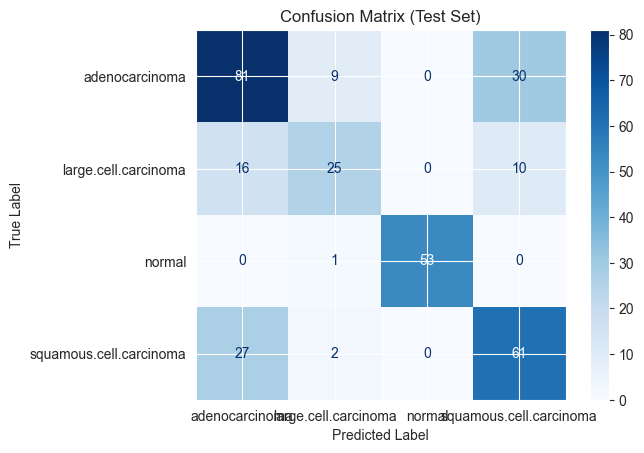


📄 Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.65      0.68      0.66       120
   large.cell.carcinoma       0.68      0.49      0.57        51
                 normal       1.00      0.98      0.99        54
squamous.cell.carcinoma       0.60      0.68      0.64        90

               accuracy                           0.70       315
              macro avg       0.73      0.71      0.72       315
           weighted avg       0.70      0.70      0.70       315



In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 🔄 Sınıf adlarını al
class_names = list(test_data.class_indices.keys())

# 🔍 Gerçek etiketleri ve tahminleri topla
y_true = []
y_pred = []

# ⚠️ test_data.shuffle = False olmalı doğru sıralama için
test_data.reset()  # Sıfırlanmazsa karışık olabilir

for i in range(len(test_data)):
    x_batch, y_batch = test_data[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    preds = saved_model.predict(x_batch)
    y_pred.extend(np.argmax(preds, axis=1))

    # 🛑 Son batch incomplete olabilir
    if (i + 1) * test_data.batch_size >= test_data.samples:
        break

# 🧮 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# 🎨 Görselleştir
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 🧾 Ekstra: classification report
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))